In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
import warnings
from mplsoccer.pitch import Pitch
import seaborn as sns
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [42]:
match_html_path = r"C:\Users\K Raghunandan\Analyst\Matches\Manchester City 3-1 Newcastle - League Cup 2025_2026 Live.html"
fotmob_matchId = 5103360

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)
dfp['shortName'] = dfp['name'].apply(get_short_name)

In [43]:
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

In [44]:
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

In [45]:
df['x'] = df['x']*1.2
df['y'] = df['y']*0.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*0.8
df['goalMouthY'] = df['goalMouthY']*0.8

In [46]:
columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

In [47]:
df = df.merge(dfp, on='playerId', how='left')

In [48]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'goalMouthZ', 'goalMouthY', 'isShot', 'isGoal', 'cardType', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'shortName'],
      dtype='object')

In [49]:
df

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,...,isShot,isGoal,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2.896464e+09,2,0,0.0,167,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man City,Newcastle,NaN,NaN,NaN,NaN,NaN
1,2.896464e+09,2,0,0.0,23,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Newcastle,Man City,NaN,NaN,NaN,NaN,NaN
2,2.896464e+09,3,0,0.0,23,59.76,40.08,0,NaN,NaN,...,NaN,NaN,NaN,Newcastle,Man City,28.0,Joe Willock,AMC,True,J. Willock
3,2.896464e+09,4,0,5.0,23,41.16,27.20,0,NaN,NaN,...,NaN,NaN,NaN,Newcastle,Man City,12.0,Malick Thiaw,DC,True,M. Thiaw
4,2.896464e+09,5,0,7.0,23,81.72,70.16,0,NaN,NaN,...,NaN,NaN,NaN,Newcastle,Man City,33.0,Dan Burn,DC,True,D. Burn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,2.896525e+09,988,92,0.0,167,0.00,0.00,97,NaN,NaN,...,NaN,NaN,NaN,Man City,Newcastle,NaN,NaN,NaN,NaN,NaN
1573,2.896525e+09,712,0,0.0,23,0.00,0.00,7,NaN,NaN,...,NaN,NaN,NaN,Newcastle,Man City,NaN,NaN,NaN,NaN,NaN
1574,2.896526e+09,992,0,0.0,167,0.00,0.00,7,NaN,NaN,...,NaN,NaN,NaN,Man City,Newcastle,NaN,NaN,NaN,NaN,NaN
1575,2.896437e+09,1,0,0.0,167,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Man City,Newcastle,NaN,NaN,NaN,NaN,NaN


In [50]:
dfp

,playerId,shirtNo,name,position,isFirstEleven,shortName
0,404852,1,James Trafford,GK,True,J. Trafford
1,394933,27,Matheus Nunes,DR,True,M. Nunes
2,122945,6,Nathan Aké,DC,True,N. Aké
3,493206,45,Abdukodir Khusanov,DC,True,A. Khusanov
4,468847,33,Nico O'Reilly,DL,True,N. O'Reilly
5,422939,14,Nico González,DMC,True,N. González
6,357073,42,Antoine Semenyo,MR,True,A. Semenyo
7,343382,4,Tijjani Reijnders,MC,True,T. Reijnders
8,331254,47,Phil Foden,MC,True,P. Foden
9,355401,21,Rayan Aït-Nouri,ML,True,R. Aït-Nouri


In [51]:
df = df[
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['endX'].notna()) & 
    (df['endY'].notna()))
]

In [52]:
df=df.reset_index()

In [53]:
df

,index,id,eventId,minute,second,teamId,x,y,expandedMinute,period,...,isShot,isGoal,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2,2.896464e+09,3,0,0.0,23,59.76,40.08,0,NaN,...,NaN,NaN,NaN,Newcastle,Man City,28.0,Joe Willock,AMC,True,J. Willock
1,3,2.896464e+09,4,0,5.0,23,41.16,27.20,0,NaN,...,NaN,NaN,NaN,Newcastle,Man City,12.0,Malick Thiaw,DC,True,M. Thiaw
2,6,2.896464e+09,6,0,8.0,23,81.72,70.16,0,NaN,...,NaN,NaN,NaN,Newcastle,Man City,33.0,Dan Burn,DC,True,D. Burn
3,7,2.896464e+09,4,0,9.0,167,33.24,25.04,0,NaN,...,NaN,NaN,NaN,Man City,Newcastle,33.0,Nico O'Reilly,DL,True,N. O'Reilly
4,14,2.896464e+09,8,0,28.0,167,43.20,0.00,0,NaN,...,NaN,NaN,NaN,Man City,Newcastle,27.0,Matheus Nunes,DR,True,M. Nunes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,1563,2.896525e+09,709,91,43.0,23,29.28,36.08,96,NaN,...,NaN,NaN,NaN,Newcastle,Man City,33.0,Dan Burn,DC,True,D. Burn
1111,1566,2.896525e+09,983,91,48.0,167,83.40,49.20,96,NaN,...,NaN,NaN,NaN,Man City,Newcastle,16.0,Rodri,Sub,NaN,Rodri
1112,1568,2.896525e+09,985,91,50.0,167,76.56,44.16,96,NaN,...,NaN,NaN,NaN,Man City,Newcastle,10.0,Rayan Cherki,Sub,NaN,R. Cherki
1113,1569,2.896525e+09,986,91,53.0,167,64.80,54.24,96,NaN,...,NaN,NaN,NaN,Man City,Newcastle,68.0,Max Alleyne,Sub,NaN,M. Alleyne


In [104]:
df_vor=df[["x","y","endX","endY","teamName","shirtNo","position","shortName","minute"]]

In [105]:
df.to_csv('players.csv', index=False)

In [106]:
df_vor

,x,y,endX,endY,teamName,shirtNo,position,shortName,minute
0,59.76,40.08,41.16,27.20,Newcastle,28.0,AMC,J. Willock,0
1,41.16,27.20,81.72,70.16,Newcastle,12.0,DC,M. Thiaw,0
2,81.72,70.16,93.96,59.04,Newcastle,33.0,DC,D. Burn,0
3,33.24,25.04,35.16,25.44,Man City,33.0,DL,N. O'Reilly,0
4,43.20,0.00,19.44,37.28,Man City,27.0,DR,M. Nunes,0
...,...,...,...,...,...,...,...,...,...
1110,29.28,36.08,38.76,29.04,Newcastle,33.0,DC,D. Burn,91
1111,83.40,49.20,80.76,44.48,Man City,16.0,Sub,Rodri,91
1112,76.56,44.16,65.52,53.76,Man City,10.0,Sub,R. Cherki,91
1113,64.80,54.24,69.72,56.96,Man City,68.0,Sub,M. Alleyne,91


In [107]:
firstSub=44

In [108]:
df_vor=df_vor[df_vor["minute"]<firstSub]

In [109]:
df_vor

,x,y,endX,endY,teamName,shirtNo,position,shortName,minute
0,59.76,40.08,41.16,27.20,Newcastle,28.0,AMC,J. Willock,0
1,41.16,27.20,81.72,70.16,Newcastle,12.0,DC,M. Thiaw,0
2,81.72,70.16,93.96,59.04,Newcastle,33.0,DC,D. Burn,0
3,33.24,25.04,35.16,25.44,Man City,33.0,DL,N. O'Reilly,0
4,43.20,0.00,19.44,37.28,Man City,27.0,DR,M. Nunes,0
...,...,...,...,...,...,...,...,...,...
485,36.36,36.96,52.44,45.68,Man City,33.0,DL,N. O'Reilly,43
486,53.04,45.12,46.56,42.48,Man City,4.0,MC,T. Reijnders,43
487,49.08,40.64,51.48,48.56,Man City,33.0,DL,N. O'Reilly,43
488,53.40,46.32,54.60,26.00,Man City,4.0,MC,T. Reijnders,43


In [110]:
df_vor["passer"]=df_vor["shirtNo"]

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21772\4059153937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor["passer"]=df_vor["shirtNo"]


In [111]:
pas=pd.to_numeric(df_vor["passer"],downcast="integer")

In [112]:
df_vor["passer"]=pas

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_21772\25595984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vor["passer"]=pas


In [113]:
df_vor

,x,y,endX,endY,teamName,shirtNo,position,shortName,minute,passer
0,59.76,40.08,41.16,27.20,Newcastle,28.0,AMC,J. Willock,0,28
1,41.16,27.20,81.72,70.16,Newcastle,12.0,DC,M. Thiaw,0,12
2,81.72,70.16,93.96,59.04,Newcastle,33.0,DC,D. Burn,0,33
3,33.24,25.04,35.16,25.44,Man City,33.0,DL,N. O'Reilly,0,33
4,43.20,0.00,19.44,37.28,Man City,27.0,DR,M. Nunes,0,27
...,...,...,...,...,...,...,...,...,...,...
485,36.36,36.96,52.44,45.68,Man City,33.0,DL,N. O'Reilly,43,33
486,53.04,45.12,46.56,42.48,Man City,4.0,MC,T. Reijnders,43,4
487,49.08,40.64,51.48,48.56,Man City,33.0,DL,N. O'Reilly,43,33
488,53.40,46.32,54.60,26.00,Man City,4.0,MC,T. Reijnders,43,4


In [114]:
df_mci=df_vor[df_vor["teamName"]=="Man City"]

In [115]:
df_mci

,x,y,endX,endY,teamName,shirtNo,position,shortName,minute,passer
3,33.24,25.04,35.16,25.44,Man City,33.0,DL,N. O'Reilly,0,33
4,43.20,0.00,19.44,37.28,Man City,27.0,DR,M. Nunes,0,27
5,19.08,43.76,6.12,38.64,Man City,6.0,DC,N. Aké,0,6
6,6.72,38.48,20.28,46.64,Man City,1.0,GK,J. Trafford,0,1
7,20.52,46.80,50.88,53.60,Man City,33.0,DL,N. O'Reilly,0,33
...,...,...,...,...,...,...,...,...,...,...
485,36.36,36.96,52.44,45.68,Man City,33.0,DL,N. O'Reilly,43,33
486,53.04,45.12,46.56,42.48,Man City,4.0,MC,T. Reijnders,43,4
487,49.08,40.64,51.48,48.56,Man City,33.0,DL,N. O'Reilly,43,33
488,53.40,46.32,54.60,26.00,Man City,4.0,MC,T. Reijnders,43,4


In [116]:
df_new=df_vor[df_vor["teamName"]=="Newcastle"]

In [117]:
df_new

,x,y,endX,endY,teamName,shirtNo,position,shortName,minute,passer
0,59.76,40.08,41.16,27.20,Newcastle,28.0,AMC,J. Willock,0,28
1,41.16,27.20,81.72,70.16,Newcastle,12.0,DC,M. Thiaw,0,12
2,81.72,70.16,93.96,59.04,Newcastle,33.0,DC,D. Burn,0,33
33,35.04,51.60,37.56,45.28,Newcastle,33.0,DC,D. Burn,2,33
34,27.36,42.56,46.20,41.84,Newcastle,8.0,MC,S. Tonali,2,8
...,...,...,...,...,...,...,...,...,...,...
466,18.12,9.04,19.08,14.56,Newcastle,2.0,MR,K. Trippier,40,2
467,22.92,13.12,21.00,5.36,Newcastle,41.0,MC,J. Ramsey,40,41
468,21.00,5.36,10.20,12.64,Newcastle,2.0,MR,K. Trippier,40,2
469,9.24,15.36,35.40,80.00,Newcastle,4.0,DC,S. Botman,40,4


In [118]:
df_mci_vor=df_mci.groupby("passer").agg({"x":["mean"],"y":["mean"]})
df_mci_vor["Team"]=0

In [119]:
df_mci_vor=df_mci_vor.reset_index()

In [120]:
df_mci_vor

,passer,x,y,Team
,,mean,mean,
0,1,12.312000,38.736000,0
1,4,75.900000,60.986667,0
2,6,46.074545,56.814545,0
3,7,79.493333,58.955556,0
4,14,68.052632,43.947368,0
5,21,67.796923,71.267692,0
6,27,68.725714,7.596190,0
7,33,54.576471,54.299608,0
8,42,87.784615,22.904615,0


In [121]:
df_new_vor=df_new.groupby("passer").agg({"x":["mean"],"y":["mean"]})
df_new_vor["Team"]=1

In [122]:
df_new_vor=df_new_vor.reset_index()

In [144]:
df_new_vor["x"]=120-df_new_vor["x"]
df_new_vor["y"]=80-df_new_vor["y"]

In [145]:
df_new_vor

,passer,x,y,Team
,,mean,mean,
0,2,68.025600,67.449600,1
1,3,63.845455,13.705455,1
2,4,92.188571,29.904762,1
3,8,58.336364,31.447273,1
4,10,51.877500,31.020000,1
5,12,78.105882,56.592941,1
6,27,76.080000,41.657143,1
7,28,49.885714,16.537143,1
8,32,107.181818,39.789091,1


In [146]:
df_voronoi = pd.concat([df_mci_vor,df_new_vor], ignore_index=True)

In [147]:
df_voronoi.columns = df_voronoi.columns.droplevel(1)

In [153]:
df_voronoi

,passer,x,y,Team
0,1,12.312000,38.736000,0
1,4,75.900000,60.986667,0
2,6,46.074545,56.814545,0
3,7,79.493333,58.955556,0
4,14,68.052632,43.947368,0
5,21,67.796923,71.267692,0
6,27,68.725714,7.596190,0
7,33,54.576471,54.299608,0
8,42,87.784615,22.904615,0
9,45,47.842105,29.448421,0


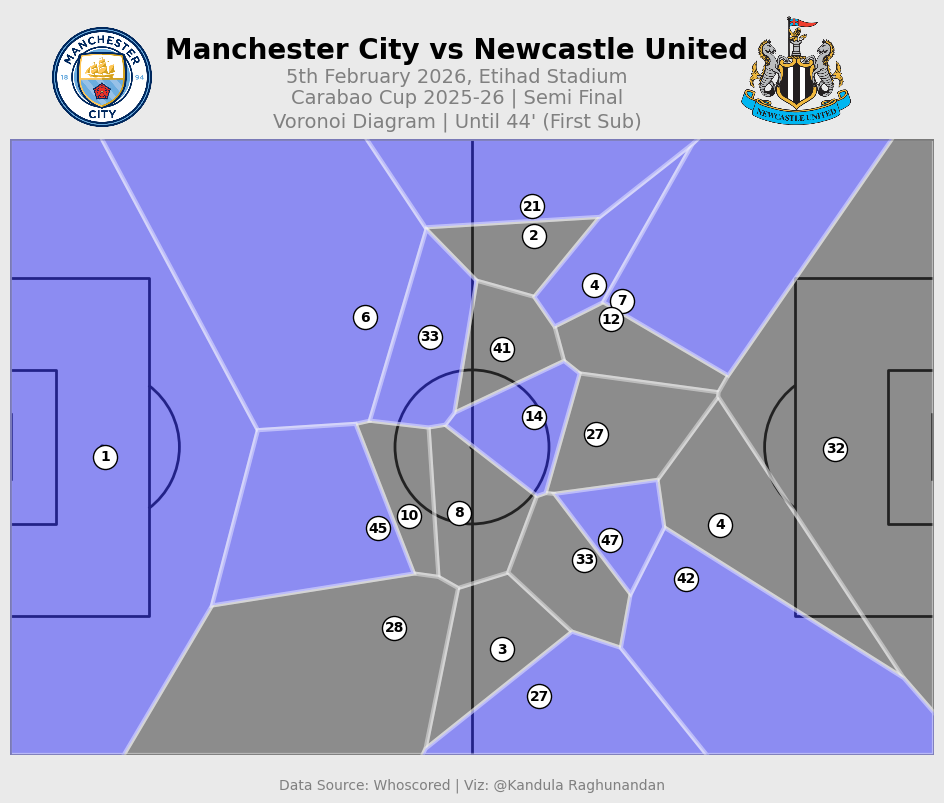

In [189]:
fig, ax= plt.subplots(figsize=(12,8))
fig.set_facecolor("#EAEAEA")
ax.patch.set_facecolor("#EAEAEA")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#EAEAEA', line_color='#3A3A3A')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

x=df_voronoi.x
y=df_voronoi.y
team1,team2=pitch.voronoi(x,y,df_voronoi.Team)

#Away Team
t1=pitch.polygon(team1,ax=ax,facecolor="black",edgecolor="white",linewidth=3,alpha=0.4)
#Home Team
t2=pitch.polygon(team2,ax=ax,facecolor="blue",edgecolor="white",linewidth=3,alpha=0.4)

ax.scatter(df_voronoi['x'], df_voronoi['y'], 
           s=300, 
           c='white', 
           edgecolors='black',
           zorder=5)

for i, row in df_voronoi.iterrows():
    ax.text(row['x'], row['y'],
        f"{int(row['passer'])}",
        ha='center', va='center',
        fontsize=10, fontweight='bold',
        color='black',
        zorder=6)

plt.text(
    0.5, -0.05, "Data Source: Whoscored | Viz: @Kandula Raghunandan",
    ha="center", va="center",
    transform=plt.gca().transAxes,
    fontsize=10, color="gray"
)

fig.text(0.5, 0.98,
         "Manchester City vs Newcastle United",
         ha="center",
         fontsize=20,
         fontweight="bold")

fig.text(0.5, 0.95,
         "5th February 2026, Etihad Stadium",
         ha="center",
         fontsize=14,
         color="grey")

fig.text(0.5, 0.925,
         "Carabao Cup 2025-26 | Semi Final",
         ha="center",
         fontsize=14,
         color="grey")

fig.text(0.5, 0.895,
         "Voronoi Diagram | Until 44' (First Sub)",
         ha="center",
         fontsize=14,
         color="grey")

home_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Manchester City.png")
away_logo = mpimg.imread("C:/Users/K Raghunandan/Analyst/Logos/Premier League/Newcastle United.png")

def add_logo(ax, img, zoom, xy):
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, xycoords='axes fraction')
    ax.add_artist(ab)

add_logo(ax, home_logo, zoom=0.2, xy=(0.1, 1.1))
add_logo(ax, away_logo, zoom=0.2, xy=(0.85, 1.11))

plt.savefig(r"C:\Users\K Raghunandan\Analyst\Matches\Manchester City 3-1 Newcastle - League Cup 2025_2026 Live_files\voronoi.jpg",bbox_inches='tight')